# Importing the required Libaries and other Functions


In [1]:
import os
import sys
 
os.environ["SPARK_HOME"] = "/usr/spark2.4.3"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
# In below two lines, use /usr/bin/python2.7 if you want to use Python 2
os.environ["PYSPARK_PYTHON"] = "/usr/local/anaconda/bin/python" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/local/anaconda/bin/python"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("appName2")
sc = SparkContext(conf=conf)

In [2]:
from pyspark.sql import SparkSession
from functools import reduce
from pyspark.sql.functions import col, lit, when
#from graphframes import *

# initialise sc
#from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, HiveContext
from pyspark.sql.types import *
#sc= SparkContext()
sqlContext = SQLContext(sc)


In [73]:
# Import libraries and other functions
from io import StringIO
from collections import namedtuple
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *

import csv
import matplotlib.pyplot as plt
import gmplot
import pandas as pd
import numpy as np


In [3]:
# test that config loaded correctly
rdd = sc.textFile("/data/mr/wordcount/input/")
print(rdd.take(10))
print(sc.version)

['The Project Gutenberg EBook of The Adventures of Sherlock Holmes', 'by Sir Arthur Conan Doyle', '(#15 in our series by Sir Arthur Conan Doyle)', '', 'Copyright laws are changing all over the world. Be sure to check the', 'copyright laws for your country before downloading or redistributing', 'this or any other Project Gutenberg eBook.', '', 'This header should be the first thing seen when viewing this Project', 'Gutenberg file.  Please do not remove it.  Do not change or edit the']
2.4.3


 # 2 Loading the road casualty dataset(casualty & accident) into rdd

In [4]:
#creating an rdd from the casualty dataset using the sc.textFile function
rdd_acc1 = sc.textFile("hdfs:///user/imat5322_482153/road-casualty-statistics-casualty-1979-2020.csv")

In [5]:
#to check if our file loaded correctly
rdd_acc1.take(2)

['accident_index,accident_year,accident_reference,vehicle_reference,casualty_reference,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile',
 '197901A11AD14,1979,01A11AD14,2,1,1,1,-1,-1,3,0,0,0,0,-1,104,-1,-1']

In [6]:
#to know the amount of observations in the dataset
rdd_acc1.count()

11449313

In [7]:
#creating an rdd from the accident dataset using the sc.textFile function and also a structured list per line using the map function
rdd_acc2 = sc.textFile("hdfs:///user/imat5322_482153/dft-road-casualty-statistics-accident-1979-2020.csv")

In [8]:
rdd_acc2.take(2)

['accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,local_authority_highway,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location',
 '197901A11AD14,1979,01A11AD14,NULL,NULL,NULL,NULL,1,3,2,1,18/01/1979,5,08:00,11,-1,-1,3,4,1,30,1,4,-1,-1,-1,-1,1,8,1,-1,0,-1,-1,-1,-1']

In [9]:
rdd_acc2.count()

8602825

In [10]:
#choosing our desired column variables from the accident dataset
rdd_acc3 = rdd_acc2.map(lambda x: x.split(',')).map(lambda x: (str(x[0]), str(x[1]), \
str(x[5]), str(x[6]), str(x[8]), str(x[9]), str(x[10]), str(x[11]), str(x[12]), str(x[13]),\
str(x[14]), str(x[19]), str(x[20]), str(x[27]), str(x[28]), str(x[29]), str(x[32]), str(x[33]))) 

In [11]:
#call an action to ensure new rdd was created
rdd_acc3.first()

('accident_index',
 'accident_year',
 'longitude',
 'latitude',
 'accident_severity',
 'number_of_vehicles',
 'number_of_casualties',
 'date',
 'day_of_week',
 'time',
 'local_authority_district',
 'road_type',
 'speed_limit',
 'light_conditions',
 'weather_conditions',
 'road_surface_conditions',
 'urban_or_rural_area',
 'did_police_officer_attend_scene_of_accident')

In [41]:
#creates a new rdd that contains the variable columns we need for our analysis and visualization
rdd_acc4 = rdd_acc1.map(lambda x: x.split(','))\
.map(lambda x: (str(x[0]), str(x[5]), str(x[6]), str(x[7]), str(x[9])))

In [42]:
#call an action to ensure new rdd was created
rdd_acc4.take(2)

[('accident_index',
  'casualty_class',
  'sex_of_casualty',
  'age_of_casualty',
  'casualty_severity'),
 ('197901A11AD14', '1', '1', '-1', '3')]

# PREPARING RDD FOR CONVERSION TO DATAFRAME 

In [43]:
#Removal of header from the created rdds to be replaced later by a claerly defined schema
#we start by creating an rdd for the headers
header1 = rdd_acc3.first()
header2 = rdd_acc4.first()

In [15]:
#checking if our header was created
header1

('accident_index',
 'accident_year',
 'longitude',
 'latitude',
 'accident_severity',
 'number_of_vehicles',
 'number_of_casualties',
 'date',
 'day_of_week',
 'time',
 'local_authority_district',
 'road_type',
 'speed_limit',
 'light_conditions',
 'weather_conditions',
 'road_surface_conditions',
 'urban_or_rural_area',
 'did_police_officer_attend_scene_of_accident')

In [44]:
#checking if our header was created
header2

('accident_index',
 'casualty_class',
 'sex_of_casualty',
 'age_of_casualty',
 'casualty_severity')

In [45]:
#Remove the headers by filtering header1 and header2 from rdd_acc3 and rdd_acc4
rdd_acc5 = rdd_acc3.filter(lambda x: x!=header1)
rdd_acc6 = rdd_acc4.filter(lambda x: x!=header2)

In [18]:
#checking if our rdds were created
#rdds without headers created
rdd_acc5.first()

('197901A11AD14',
 '1979',
 'NULL',
 'NULL',
 '3',
 '2',
 '1',
 '18/01/1979',
 '5',
 '08:00',
 '11',
 '1',
 '30',
 '1',
 '8',
 '1',
 '-1',
 '-1')

In [46]:
#rdd without header created
rdd_acc6.first()

('197901A11AD14', '1', '1', '-1', '3')

In [20]:
#creating a defined schema for rdd_acc5 for conversion to dataframe
Acc_Schema = StructType([\
StructField('Accident_Index', StringType(), True), \
StructField('Accident_Year', StringType(), True), \
StructField('Longitude', StringType(), True), \
StructField('Latitude', StringType(), True), \
StructField('Accident_Severity', StringType(), True), \
StructField('Number_of_Vehicles', StringType(), True), \
StructField('Number_of_Casualties', StringType(), True), \
StructField('Date', StringType(), True), \
StructField('Day_of_Week', StringType(), True), \
StructField('Time', StringType(), True), \
StructField('Local_Authority_District', StringType(), True), \
StructField('Road_Type', StringType(), True), \
StructField('Speed_Limit', StringType(), True), \
StructField('Light_Conditions', StringType(), True), \
StructField('Weather_Conditions', StringType(), True), \
StructField('Road_Surface_Conditions', StringType(), True), \
StructField('Area_Type', StringType(), True), \
StructField('Police_Officer_attend_accident', StringType(), True)])


In [50]:
#creating a defined schema for rdd_acc6 for conversion to a dataframe
Cas_Schema= StructType([\
StructField('Accident_Index1', StringType(), True), \
StructField('Casualty_Class', StringType(), True), \
StructField('Sex', StringType(), True), \
StructField('Age', StringType(), True), \
StructField('Casualty_Severity', StringType(), True)])


In [22]:
#creating a dataframe(accidents) from rdd_acc5 and our defined schema
accidents = sqlContext.createDataFrame(rdd_acc5, Acc_Schema)

In [51]:
#creating a dataframe(Casualties) from rdd_acc6 and our defined schema
casualties = sqlContext.createDataFrame(rdd_acc6, Cas_Schema)

In [24]:
#checking our applied schema for the accident dataframe
accidents.printSchema()

root
 |-- Accident_Index: string (nullable = true)
 |-- Accident_Year: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Accident_Severity: string (nullable = true)
 |-- Number_of_Vehicles: string (nullable = true)
 |-- Number_of_Casualties: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Day_of_Week: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Local_Authority_District: string (nullable = true)
 |-- Road_Type: string (nullable = true)
 |-- Speed_Limit: string (nullable = true)
 |-- Light_Conditions: string (nullable = true)
 |-- Weather_Conditions: string (nullable = true)
 |-- Road_Surface_Conditions: string (nullable = true)
 |-- Area_Type: string (nullable = true)
 |-- Police_Officer_attend_accident: string (nullable = true)



In [52]:
#checking our defined schema for the Casualties dataframe
casualties.printSchema()

root
 |-- Accident_Index1: string (nullable = true)
 |-- Casualty_Class: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Casualty_Severity: string (nullable = true)



In [26]:
#Checking if the accident dataframe ran correctly
accidents.show()

+--------------+-------------+---------+--------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+---------+-----------+----------------+------------------+-----------------------+---------+------------------------------+
|Accident_Index|Accident_Year|Longitude|Latitude|Accident_Severity|Number_of_Vehicles|Number_of_Casualties|      Date|Day_of_Week| Time|Local_Authority_District|Road_Type|Speed_Limit|Light_Conditions|Weather_Conditions|Road_Surface_Conditions|Area_Type|Police_Officer_attend_accident|
+--------------+-------------+---------+--------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+---------+-----------+----------------+------------------+-----------------------+---------+------------------------------+
| 197901A11AD14|         1979|     NULL|    NULL|                3|                 2|                   1|18/01/1979|          5|08:00|         

In [53]:
#Checking if the casualties dataframe ran correctly
casualties.show()

+---------------+--------------+---+---+-----------------+
|Accident_Index1|Casualty_Class|Sex|Age|Casualty_Severity|
+---------------+--------------+---+---+-----------------+
|  197901A11AD14|             1|  1| -1|                3|
|  197901A1BAW34|             3|  2| 27|                3|
|  197901A1BFD77|             1|  1| 21|                3|
|  197901A1BFD77|             2|  1| 20|                3|
|  197901A1BFD77|             1|  1| 35|                3|
|  197901A1BGC20|             2|  1| 52|                3|
|  197901A1BGC20|             2|  2| 46|                3|
|  197901A1BGF95|             2|  2| 62|                2|
|  197901A1CBC96|             3|  1| -1|                3|
|  197901A1DAK71|             2|  1| 38|                3|
|  197901A1DAK71|             1|  1| 24|                3|
|  197901A1DAP95|             2|  2| 20|                3|
|  197901A1EAC32|             3|  1| 21|                2|
|  197901A1FBK75|             1|  1| 25|                

In [32]:
#filter out the years we need(2010-2020) using filter and isin commands from accident and casualties dataframe
#filter out all local authorities under Leicestershire with their district codes using filter and isin command

Leicestershire_acc = accidents.filter(accidents.Accident_Year.isin(\
["2010","2011","2012","2013","2014","2015","2016","2017","2018","2019","2020"])).filter\
(accidents.Local_Authority_District.isin(["360","361","362","363","364","365","366","367","368"])) 

Leicestershire_acc.show()   #run an action to see if our code runs successfully


+--------------+-------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+---------+-----------+----------------+------------------+-----------------------+---------+------------------------------+
|Accident_Index|Accident_Year|Longitude| Latitude|Accident_Severity|Number_of_Vehicles|Number_of_Casualties|      Date|Day_of_Week| Time|Local_Authority_District|Road_Type|Speed_Limit|Light_Conditions|Weather_Conditions|Road_Surface_Conditions|Area_Type|Police_Officer_attend_accident|
+--------------+-------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+---------+-----------+----------------+------------------+-----------------------+---------+------------------------------+
| 2010331000007|         2010|-1.159826|52.601438|                3|                 2|                   1|04/01/2010|          2|12:55|     

In [54]:
#Merge accidents and casualties together using join command(this is to help us select districts which is only available in accident dataset)
#filter out the years we need(2010-2020) using filter and isin commands from the merged dataframes
#filter out all local authorities under Leicestershire with their district codes using filter and isin command

Leicestershire_cas = accidents.join(casualties, accidents.Accident_Index == casualties.Accident_Index1, how='full').drop(col("Accident_Index1")).filter(accidents.Accident_Year.isin(\
["2010","2011","2012","2013","2014","2015","2016","2017","2018","2019","2020"])).filter\
(accidents.Local_Authority_District.isin(["360","361","362","363","364","365","366","367","368"])) 


Leicestershire_cas.show()   #run an action to see if our code runs successfully

+--------------+-------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+---------+-----------+----------------+------------------+-----------------------+---------+------------------------------+--------------+---+---+-----------------+
|Accident_Index|Accident_Year|Longitude| Latitude|Accident_Severity|Number_of_Vehicles|Number_of_Casualties|      Date|Day_of_Week| Time|Local_Authority_District|Road_Type|Speed_Limit|Light_Conditions|Weather_Conditions|Road_Surface_Conditions|Area_Type|Police_Officer_attend_accident|Casualty_Class|Sex|Age|Casualty_Severity|
+--------------+-------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+---------+-----------+----------------+------------------+-----------------------+---------+------------------------------+--------------+---+---+-----------------+
| 2010331001236|   

In [55]:
#replacing some column values with characters using regexp_replace 

from pyspark.sql.functions import regexp_replace
Leicestershire_cas1 = Leicestershire_cas.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '1', 'Sunday'))\
.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '2', 'Monday'))\
.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '3', 'Tuesday'))\
.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '4', 'Wednesday'))\
.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '5', 'Thursday'))\
.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '6', 'Friday'))\
.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '7', 'Saturday'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '360', 'Blaby'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '361', 'Hinckley and Bosworth'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '362', 'Charnwood'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '363', 'Harborough'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '364', 'Leicester'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '365', 'Melton'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '366', 'North West Leicestershire'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '367', 'Oadby and Wigston'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '368', 'Rutland'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '1', 'Roundabout'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '2', 'One Way Street'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '3', 'Dual Carriageway'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '6', 'Single Carriageway'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '7', 'Slip Road'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '12', 'One Way/Slip Road'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '-1', 'null'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '9', 'unknown'))\
.withColumn('Light_Conditions', regexp_replace('Light_Conditions', '1', 'Daylight'))\
.withColumn('Light_Conditions', regexp_replace('Light_Conditions', '4', 'Dark/lights lit'))\
.withColumn('Light_Conditions', regexp_replace('Light_Conditions', '5', 'Dark/Lights unlit'))\
.withColumn('Light_Conditions', regexp_replace('Light_Conditions', '6', 'Darkn/no Lighting'))\
.withColumn('Light_Conditions', regexp_replace('Light_Conditions', '7', 'Dark/ Lighting Unknown'))\
.withColumn('Light_Conditions', regexp_replace('Light_Conditions', '-1', 'null'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '1', 'Fine'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '2', 'Rain no high winds'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '3', 'Snow no high winds'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '4', 'Fine high winds '))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '5', 'Rain and High winds'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '6', 'Snow and High winds'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '7', 'Fog or Mist'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '8', 'Other'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '9', 'Unknown'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '-1', 'null'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '1', 'Dry'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '2', 'Wet'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '3', 'Snow'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '4', 'Frost/Ice'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '5', 'Flood/over 3cm deep'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '6', 'Oil/Diesel'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '7', 'Mud'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '-1', 'null'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '9', 'unknown'))\
.withColumn('Area_Type', regexp_replace('Area_Type', '1', 'Urban'))\
.withColumn('Area_Type', regexp_replace('Area_Type', '2', 'Rural'))\
.withColumn('Area_Type', regexp_replace('Area_Type', '3', 'Unallocated'))\
.withColumn('Area_Type', regexp_replace('Area_Type', '-1', 'missing'))\
.withColumn('Police_Officer_Attend_Accident', regexp_replace('Police_Officer_Attend_Accident', '1', 'Yes'))\
.withColumn('Police_Officer_Attend_Accident', regexp_replace('Police_Officer_Attend_Accident', '2', 'No'))\
.withColumn('Police_Officer_Attend_Accident', regexp_replace('Police_Officer_Attend_Accident', '3', 'No/Self Reported'))\
.withColumn('Police_Officer_Attend_Accident', regexp_replace('Police_Officer_Attend_Accident', '-1', 'null'))\
.withColumn('Casualty_Class', regexp_replace('Casualty_Class', '1', 'Driver/Rider'))\
.withColumn('Casualty_Class', regexp_replace('Casualty_Class', '2', 'Passenger'))\
.withColumn('Casualty_Class', regexp_replace('Casualty_Class', '3', 'Pedestrian'))\
.withColumn('Sex', regexp_replace('Sex', '1', 'Male'))\
.withColumn('Sex', regexp_replace('Sex', '2', 'Female'))\
.withColumn('Sex', regexp_replace('Sex', '9', 'unknown'))\
.withColumn('Sex', regexp_replace('Sex', '-1', 'null'))\
.withColumn('Casualty_Severity', regexp_replace('Casualty_Severity', '1', 'Fatal'))\
.withColumn('Casualty_Severity', regexp_replace('Casualty_Severity', '2', 'Serious'))\
.withColumn('Casualty_Severity', regexp_replace('Casualty_Severity', '3', 'Slight'))\
.withColumn('Accident_Severity', regexp_replace('Accident_Severity', '1', 'Fatal'))\
.withColumn('Accident_Severity', regexp_replace('Accident_Severity', '2', 'Serious'))\
.withColumn('Accident_Severity', regexp_replace('Accident_Severity', '3', 'Slight'))


In [37]:
Leicestershire_acc1 = Leicestershire_acc.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '1', 'Sunday'))\
.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '2', 'Monday'))\
.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '3', 'Tuesday'))\
.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '4', 'Wednesday'))\
.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '5', 'Thursday'))\
.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '6', 'Friday'))\
.withColumn('Day_of_Week', regexp_replace('Day_of_Week', '7', 'Saturday'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '360', 'Blaby'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '361', 'Hinckley and Bosworth'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '362', 'Charnwood'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '363', 'Harborough'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '364', 'Leicester'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '365', 'Melton'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '366', 'North West Leicestershire'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '367', 'Oadby and Wigston'))\
.withColumn('Local_Authority_District', regexp_replace('Local_Authority_District', '368', 'Rutland'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '1', 'Roundabout'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '2', 'One Way Street'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '3', 'Dual Carriageway'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '6', 'Single Carriageway'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '7', 'Slip Road'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '12', 'One Way/Slip Road'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '-1', 'null'))\
.withColumn('Road_Type', regexp_replace('Road_Type', '9', 'unknown'))\
.withColumn('Light_Conditions', regexp_replace('Light_Conditions', '1', 'Daylight'))\
.withColumn('Light_Conditions', regexp_replace('Light_Conditions', '4', 'Dark/lights lit'))\
.withColumn('Light_Conditions', regexp_replace('Light_Conditions', '5', 'Dark/Lights unlit'))\
.withColumn('Light_Conditions', regexp_replace('Light_Conditions', '6', 'Darkn/no Lighting'))\
.withColumn('Light_Conditions', regexp_replace('Light_Conditions', '7', 'Dark/ Lighting Unknown'))\
.withColumn('Light_Conditions', regexp_replace('Light_Conditions', '-1', 'null'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '1', 'Fine'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '2', 'Rain no high winds'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '3', 'Snow no high winds'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '4', 'Fine high winds '))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '5', 'Rain and High winds'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '6', 'Snow and High winds'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '7', 'Fog or Mist'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '8', 'Other'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '9', 'Unknown'))\
.withColumn('Weather_Conditions', regexp_replace('Weather_Conditions', '-1', 'null'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '1', 'Dry'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '2', 'Wet'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '3', 'Snow'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '4', 'Frost/Ice'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '5', 'Flood/over 3cm deep'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '6', 'Oil/Diesel'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '7', 'Mud'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '-1', 'null'))\
.withColumn('Road_Surface_Conditions', regexp_replace('Road_Surface_Conditions', '9', 'unknown'))\
.withColumn('Area_Type', regexp_replace('Area_Type', '1', 'Urban'))\
.withColumn('Area_Type', regexp_replace('Area_Type', '2', 'Rural'))\
.withColumn('Area_Type', regexp_replace('Area_Type', '3', 'Unallocated'))\
.withColumn('Area_Type', regexp_replace('Area_Type', '-1', 'null'))\
.withColumn('Police_Officer_Attend_Accident', regexp_replace('Police_Officer_Attend_Accident', '1', 'Yes'))\
.withColumn('Police_Officer_Attend_Accident', regexp_replace('Police_Officer_Attend_Accident', '2', 'No'))\
.withColumn('Police_Officer_Attend_Accident', regexp_replace('Police_Officer_Attend_Accident', '3', 'No/Self Reported'))\
.withColumn('Police_Officer_Attend_Accident', regexp_replace('Police_Officer_Attend_Accident', '-1', 'null'))\
.withColumn('Accident_Severity', regexp_replace('Accident_Severity', '1', 'Fatal'))\
.withColumn('Accident_Severity', regexp_replace('Accident_Severity', '2', 'Serious'))\
.withColumn('Accident_Severity', regexp_replace('Accident_Severity', '3', 'Slight'))


In [38]:
Leicestershire_acc1.show()

+--------------+-------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+------------------+-----------+-----------------+------------------+-----------------------+---------+------------------------------+
|Accident_Index|Accident_Year|Longitude| Latitude|Accident_Severity|Number_of_Vehicles|Number_of_Casualties|      Date|Day_of_Week| Time|Local_Authority_District|         Road_Type|Speed_Limit| Light_Conditions|Weather_Conditions|Road_Surface_Conditions|Area_Type|Police_Officer_Attend_Accident|
+--------------+-------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+------------------+-----------+-----------------+------------------+-----------------------+---------+------------------------------+
| 2010331000007|         2010|-1.159826|52.601438|           Slight|                 2|                   1|04/0

In [56]:
Leicestershire_cas1.show()

+--------------+-------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+------------------+-----------+-----------------+------------------+-----------------------+---------+------------------------------+--------------+------+---+-----------------+
|Accident_Index|Accident_Year|Longitude| Latitude|Accident_Severity|Number_of_Vehicles|Number_of_Casualties|      Date|Day_of_Week| Time|Local_Authority_District|         Road_Type|Speed_Limit| Light_Conditions|Weather_Conditions|Road_Surface_Conditions|Area_Type|Police_Officer_Attend_Accident|Casualty_Class|   Sex|Age|Casualty_Severity|
+--------------+-------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+------------------+-----------+-----------------+------------------+-----------------------+---------+------------------------------+--------------+------+---

In [65]:
#Change datatype of some columns of created dataframe from string to appropraite types

Leicestershire_cas2 = Leicestershire_cas1.withColumn("Latitude",Leicestershire_cas1["Latitude"].cast(DoubleType()))\
.withColumn("Longitude",Leicestershire_cas1["Longitude"].cast(DoubleType()))\
.withColumn("Accident_Year",Leicestershire_cas1["Accident_Year"].cast(IntegerType()))\
.withColumn("Number_of_Casualties",Leicestershire_cas1["Number_of_Casualties"].cast(FloatType()))\
.withColumn("Number_of_Vehicles",Leicestershire_cas1["Number_of_Vehicles"].cast(FloatType()))\
.withColumn("Age",Leicestershire_cas1["Age"].cast(IntegerType()))\
.withColumn("Speed_Limit",Leicestershire_cas1["Speed_Limit"].cast(IntegerType()))


In [66]:
#Change datatype of some columns of created dataframe from string to appropraite types

Leicestershire_acc2 = Leicestershire_acc1.withColumn("Latitude",Leicestershire_acc1["Latitude"].cast(DoubleType()))\
.withColumn("Longitude",Leicestershire_acc1["Longitude"].cast(DoubleType()))\
.withColumn("Accident_Year",Leicestershire_acc1["Accident_Year"].cast(IntegerType()))\
.withColumn("Number_of_Casualties",Leicestershire_acc1["Number_of_Casualties"].cast(FloatType()))\
.withColumn("Number_of_Vehicles",Leicestershire_acc1["Number_of_Vehicles"].cast(FloatType()))\
.withColumn("Speed_Limit",Leicestershire_acc1["Speed_Limit"].cast(IntegerType()))


In [67]:
#run an action to check if datatype has been changed
Leicestershire_cas2.printSchema()

root
 |-- Accident_Index: string (nullable = true)
 |-- Accident_Year: integer (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Accident_Severity: string (nullable = true)
 |-- Number_of_Vehicles: float (nullable = true)
 |-- Number_of_Casualties: float (nullable = true)
 |-- Date: string (nullable = true)
 |-- Day_of_Week: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Local_Authority_District: string (nullable = true)
 |-- Road_Type: string (nullable = true)
 |-- Speed_Limit: integer (nullable = true)
 |-- Light_Conditions: string (nullable = true)
 |-- Weather_Conditions: string (nullable = true)
 |-- Road_Surface_Conditions: string (nullable = true)
 |-- Area_Type: string (nullable = true)
 |-- Police_Officer_Attend_Accident: string (nullable = true)
 |-- Casualty_Class: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Casualty_Severity: string (nullable = t

In [68]:
#run an action to check if datatype has been changed
Leicestershire_acc2.printSchema()

root
 |-- Accident_Index: string (nullable = true)
 |-- Accident_Year: integer (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Accident_Severity: string (nullable = true)
 |-- Number_of_Vehicles: float (nullable = true)
 |-- Number_of_Casualties: float (nullable = true)
 |-- Date: string (nullable = true)
 |-- Day_of_Week: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Local_Authority_District: string (nullable = true)
 |-- Road_Type: string (nullable = true)
 |-- Speed_Limit: integer (nullable = true)
 |-- Light_Conditions: string (nullable = true)
 |-- Weather_Conditions: string (nullable = true)
 |-- Road_Surface_Conditions: string (nullable = true)
 |-- Area_Type: string (nullable = true)
 |-- Police_Officer_Attend_Accident: string (nullable = true)



In [69]:
Leicestershire_cas2.show()

+--------------+-------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+------------------+-----------+-----------------+------------------+-----------------------+---------+------------------------------+--------------+------+---+-----------------+
|Accident_Index|Accident_Year|Longitude| Latitude|Accident_Severity|Number_of_Vehicles|Number_of_Casualties|      Date|Day_of_Week| Time|Local_Authority_District|         Road_Type|Speed_Limit| Light_Conditions|Weather_Conditions|Road_Surface_Conditions|Area_Type|Police_Officer_Attend_Accident|Casualty_Class|   Sex|Age|Casualty_Severity|
+--------------+-------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+------------------+-----------+-----------------+------------------+-----------------------+---------+------------------------------+--------------+------+---

In [70]:
Leicestershire_acc2.show()

+--------------+-------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+------------------+-----------+-----------------+------------------+-----------------------+---------+------------------------------+
|Accident_Index|Accident_Year|Longitude| Latitude|Accident_Severity|Number_of_Vehicles|Number_of_Casualties|      Date|Day_of_Week| Time|Local_Authority_District|         Road_Type|Speed_Limit| Light_Conditions|Weather_Conditions|Road_Surface_Conditions|Area_Type|Police_Officer_Attend_Accident|
+--------------+-------------+---------+---------+-----------------+------------------+--------------------+----------+-----------+-----+------------------------+------------------+-----------+-----------------+------------------+-----------------------+---------+------------------------------+
| 2010331000007|         2010|-1.159826|52.601438|           Slight|               2.0|                 1.0|04/0

In [74]:
i = 0 # reset counter
#get the total records amount
total = Leicestershire_acc2.count()

print("Total Records = " + str(total))

#print the amount of coumns
print("Total columns = " + str(len(Leicestershire_acc2.columns)))
print("------------------------------------------")

#loop entire table and get the missing value number and missing rate of each column
while i < len(Leicestershire_acc2.columns): #loop through all columns
    print(str(i+1) + "." + str(Leicestershire_acc2[i]))
    print("  Missing Values = ") 
    print("------------------------------------------")
    
    Leicestershire_acc2.select([count(when(Leicestershire_acc2[i].isNull(),\
                                        True))]).show() #check for missing values
    i = i+1 #counter add 1


Total Records = 22523
Total columns = 18
------------------------------------------
1.Column<b'Accident_Index'>
  Missing Values = 
------------------------------------------
+-------------------------------------------------------+
|count(CASE WHEN (Accident_Index IS NULL) THEN true END)|
+-------------------------------------------------------+
|                                                      0|
+-------------------------------------------------------+

2.Column<b'Accident_Year'>
  Missing Values = 
------------------------------------------
+------------------------------------------------------+
|count(CASE WHEN (Accident_Year IS NULL) THEN true END)|
+------------------------------------------------------+
|                                                     0|
+------------------------------------------------------+

3.Column<b'Longitude'>
  Missing Values = 
------------------------------------------
+--------------------------------------------------+
|count(CASE WHEN (L

In [75]:
#reset counter
i=0

print("------------------------------------------")

#loop each column and get the descriptionof each one
while i < len(Leicestershire_acc2.columns):
    mv = Leicestershire_acc2.where(Leicestershire_acc2[i] =='').count() #get the missing value number of current column
    print(str(i+1) + "." + str(Leicestershire_acc2[i]))
    Leicestershire_acc2.where(Leicestershire_acc2[i] !='').describe(Leicestershire_acc2.columns[i]).show()
    print("------------------------------------------")
    i = i+1 #counter add 1


------------------------------------------
1.Column<b'Accident_Index'>
+-------+--------------------+
|summary|      Accident_Index|
+-------+--------------------+
|  count|               22523|
|   mean|2.014593426983404E12|
| stddev| 2.978124384229239E9|
|    min|       2010331000007|
|    max|       2020332001253|
+-------+--------------------+

------------------------------------------
2.Column<b'Accident_Year'>
+-------+-------------+
|summary|Accident_Year|
+-------+-------------+
|  count|            0|
|   mean|         null|
| stddev|         null|
|    min|         null|
|    max|         null|
+-------+-------------+

------------------------------------------
3.Column<b'Longitude'>
+-------+---------+
|summary|Longitude|
+-------+---------+
|  count|        0|
|   mean|     null|
| stddev|     null|
|    min|     null|
|    max|     null|
+-------+---------+

------------------------------------------
4.Column<b'Latitude'>
+-------+--------+
|summary|Latitude|
+-------+---

In [37]:
#get the casualty counts for each year ordered in descending order
acc_cas2.groupby("Accident_Year").count().orderBy(desc("count")).show()

+-------------+-----+
|Accident_Year|count|
+-------------+-----+
|         2010| 3513|
|         2011| 3342|
|         2012| 3287|
|         2014| 3240|
|         2013| 3193|
|         2015| 2942|
|         2016| 2924|
|         2017| 2219|
|         2018| 2141|
|         2019| 1769|
|         2020| 1491|
+-------------+-----+



In [36]:
from io import StringIO
from collections import namedtuple
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *


In [35]:
#retrieve yearly amount of crimes sorted descendantly
acc_cas2.select(LondonCrime.Month, ).\
.groupby("Year").count().orderBy(desc("count")).show()

SyntaxError: invalid syntax (<ipython-input-35-d78aee80404e>, line 3)

In [52]:

from pyspark.sql.functions import udf
 age_range = udf(lambda age: '0-5' if age <= 5 else 
                       '6-10' if (age >= 6 and age <= 10) else
                       '11-15' if (age >=  and age < 30) else
                       '30-35' if (age >= 30 and age < 35) else
                       '35-40' if (age >= 35 and age < 40) else
                       '40-45' if (age >= 40 and age < 45) else
                       '45-50' if (age >= 45 and age < 50) else
                       '50-55' if (age >= 50 and age < 55) else
                       '55-60' if (age >= 55 and age < 60) else
                       '60-65' if (age >= 60 and age < 65) else
                       '65-70' if (age >= 65 and age < 70) else
                        '75+'  if (age >= 70) else '')

 

In [49]:
from pyspark.sql.functions import countDistinct
accident_count = acc_cas2.select(countDistinct("Accident_Index", "Accident_Index"))
accident_count.show()

+----------------------------------------------+
|count(DISTINCT Accident_Index, Accident_Index)|
+----------------------------------------------+
|                                         22523|
+----------------------------------------------+



In [39]:

#Register our created acc_cas dataframe as a table
sqlContext.registerDataFrameAsTable(acc_cas2, "Leicestershire_Acc") 22523

In [ ]:
sqlContext.sql("select * from Leicestershire_Acc").take(2)

In [47]:
#Count Distinct Accident indexes to 
sqlContext.sql("SELECT distinct(count(Accident_Year)) FROM Leicestershire_Acc").show()

+--------------------+
|count(Accident_Year)|
+--------------------+
|               30061|
+--------------------+



In [ ]:
import pixiedust


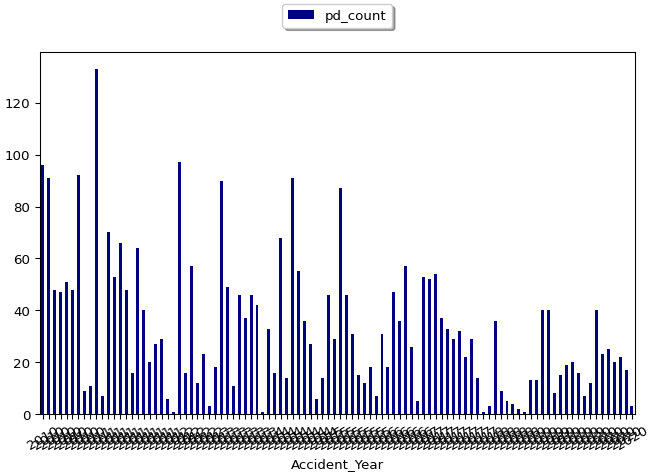

In [ ]:
display(acc_cas)